# Model training

In [29]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "reutilizabile"))
%load_ext autoreload
%autoreload 2
os.environ["OMP_NUM_THREADS"] = "4"
from common_imports import *
from missing_freq_unique import *
from feature_engineering import *
from plots import *
from blob import load_blob_csv_to_df
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
import streamlit as st
import streamlit.components.v1 as components
from azure.storage.blob import BlobServiceClient
from dotenv import load_dotenv
import inspect
import joblib
load_dotenv()

#Load env variables
connection_string = os.getenv("AZURE_STORAGE_CONNECTION_STRING")
container = os.getenv("AZURE_STORAGE_CONTAINER", "jobs")
blob_name = os.getenv("AZURE_STORAGE_BLOB", "job_description.csv")

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
!pip freeze > requirements.txt

## Read the dataset from Azure blob storage

In [19]:
df = load_blob_csv_to_df(connection_string, container, blob_name)

In [42]:
print(len(df))

1408970


In [3]:
df.head()

,Qualifications,location,Country,Work Type,Job Posting Date,Job Portal,Job Description,skills,Responsibilities,Company,Min_Salary,Max_Salary,Average_Salary,Salary_Tercile,Salary,Bonuses and Incentive Programs,Casual Dress Code,Childcare Assistance,Employee Assistance Programs (EAP),Employee Discounts,Employee Recognition Programs,Employee Referral Programs,Financial Counseling,Flexible Spending Accounts (FSAs),Flexible Work Arrangements,Health Insurance,Health and Wellness Facilities,Legal Assistance,Life and Disability Insurance,Paid Time Off (PTO),Parental Leave,Professional Development,Profit-Sharing,Relocation Assistance,Retirement Plans,Social and Recreational Activities,Stock Options or Equity Grants,Transportation Benefits,Tuition Reimbursement,Wellness Programs,Average_experience,Job Area,Job Category,Role cluster,Role Area,Company size
0,M.Tech,Douglas,Isle of Man,Intern,2022-04-24,Snagajob,"Social Media Managers oversee an organizations social media presence. They create and schedule content, engage with followers, and analyze social media metrics to drive brand awareness and engagement.","Social media platforms (e.g., Facebook, Twitter, Instagram) Content creation and scheduling Social media analytics and insights Community engagement Paid social advertising","Manage and grow social media accounts, create engaging content, and interact with the online community. Develop social media content calendars and strategies. Monitor social media trends and engagement metrics.",Icahn Enterprises,253700.0,425700.0,339700.0,Medium,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,10,11,"Sales, Marketing, and Supply Chain Management",6,Social Media & Brand Strategist,Small
1,BCA,Ashgabat,Turkmenistan,Intern,2022-12-19,Idealist,"Frontend Web Developers design and implement user interfaces for websites, ensuring they are visually appealing and user-friendly. They collaborate with designers and backend developers to create seamless web experiences for users.","HTML, CSS, JavaScript Frontend frameworks (e.g., React, Angular) User experience (UX)","Design and code user interfaces for websites, ensuring a seamless and visually appealing user experience. Collaborate with UX designers to optimize user journeys. Ensure cross-browser compatibility and responsive design.",PNC Financial Services Group,240800.0,498800.0,369800.0,Medium,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,7,0,Front-End Developer,16,Web and Application Development Specialists,Large
2,PhD,Macao,"Macao SAR, China",Temporary,2022-09-14,Jobs2Careers,"Quality Control Managers establish and enforce quality standards within an organization. They develop quality control processes, perform inspections, and implement corrective actions to maintain product or service quality.","Quality control processes and methodologies Statistical process control (SPC) Root cause analysis and corrective action Quality management systems (e.g., ISO 9001) Compliance and regulatory knowledge",Establish and enforce quality control standards and procedures. Conduct quality audits and inspections. Collaborate with production teams to address quality issues and implement improvements.,United Services Automobile Assn.,262300.0,447200.0,354750.0,Medium,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,6,2,Operations and Management,23,Quality Management and Customer Success,Medium
3,PhD,Porto-Novo,Benin,Full-Time,2023-02-25,FlexJobs,"Wireless Network Engineers design, implement, and maintain wireless network solutions. They optimize wireless connectivity, troubleshoot issues, and ensure reliable and secure wireless communications.",Wireless network design and architecture Wi-Fi standards and protocols RF (Radio Frequency) planning and optimization Wireless security protocols Troubleshooting wireless network issues,"Design, configure, and optimize wireless networks, ensuring reliable and secure wireless connectivity. Troubleshoot wireless network issues. Plan and implement wireless network upg

In [43]:
target_column = "Salary_Tercile" #the desired prediction
feature_columns = [
    "Qualifications",
    "Average_experience",
    "Work Type",
    "Company size",
    "Job Area",
    "Role cluster",
    "Bonuses and Incentive Programs",
    "Casual Dress Code",
    "Childcare Assistance",
    "Employee Assistance Programs (EAP)",
    "Employee Discounts",
    "Employee Recognition Programs",
    "Employee Referral Programs",
    "Financial Counseling",
    "Flexible Spending Accounts (FSAs)",
    "Flexible Work Arrangements",
    "Health Insurance",
    "Health and Wellness Facilities",
    "Legal Assistance",
    "Life and Disability Insurance",
    "Paid Time Off (PTO)",
    "Parental Leave",
    "Professional Development",
    "Profit-Sharing",
    "Relocation Assistance",
    "Retirement Plans",
    "Social and Recreational Activities",
    "Stock Options or Equity Grants",
    "Transportation Benefits",
    "Tuition Reimbursement",
    "Wellness Programs"
] #features taken into account for the model

# Assign X,Y with features and target

X = df[feature_columns]
Y = df[target_column]

# Split the dataset for training 80% and testing 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
categorical_features = [
    'Qualifications',
    'Work Type',
    'Company size'
]

numerical_features = [
    'Average_experience',
    'Job Area',
    'Role cluster',
    'Bonuses and Incentive Programs',
    'Casual Dress Code',
    'Childcare Assistance',
    'Employee Assistance Programs (EAP)',
    'Employee Discounts',
    'Employee Recognition Programs',
    'Employee Referral Programs',
    'Financial Counseling',
    'Flexible Spending Accounts (FSAs)',
    'Flexible Work Arrangements',
    'Health Insurance',
    'Health and Wellness Facilities',
    'Legal Assistance',
    'Life and Disability Insurance',
    'Paid Time Off (PTO)',
    'Parental Leave',
    'Professional Development',
    'Profit-Sharing',
    'Relocation Assistance',
    'Retirement Plans',
    'Social and Recreational Activities',
    'Stock Options or Equity Grants',
    'Transportation Benefits',
    'Tuition Reimbursement',
    'Wellness Programs'
]

preprocessor = ColumnTransformer(
	transformers=[
		('cat', OneHotEncoder(), categorical_features), # One-hot encode categorical features
		('num', StandardScaler(), numerical_features) # Leave these columns as they are
	]
)

## Train linear regression model

In [44]:
model1 = Pipeline(steps=[
	('preprocessor', preprocessor),
	('classifier', LogisticRegression(max_iter=1000))
])
model1.fit(X_train, y_train)
joblib.dump(model1, 'model1.pkl')

['model1.pkl']

## Make prediction

In [45]:
y_pred1 = model1.predict(X_test)

## Model evaluation

Accuracy: 0.33411641127916136, Precision: 0.334590883271282, Recall: 0.33411641127916136, f1 score: 0.3202890097744204


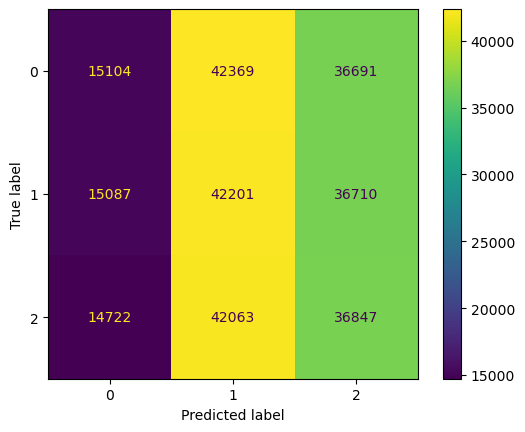

In [25]:
accuracy = accuracy_score(y_test, y_pred1)
precision = precision_score(y_test, y_pred1, average='weighted')
recall = recall_score(y_test, y_pred1, average='weighted')
f1 = f1_score(y_test, y_pred1, average='weighted')
cm = confusion_matrix(y_test, y_pred1)
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, f1 score: {f1}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Random forest classifier

In [4]:
model2 = Pipeline(steps=[
	('preprocessor', preprocessor),
	('classifier', RandomForestClassifier(
		n_estimators=100,
		random_state=42,
		n_jobs=-1))
])
model2.fit(X_train, y_train)
joblib.dump(model2, 'model2.pkl')

['model2.pkl']

In [5]:
model2 = joblib.load('model2.pkl')
y_pred2 = model2.predict(X_test)

Accuracy: 0.3332576279125886, Precision: 0.33326162773793827, Recall: 0.3332576279125886, f1 score: 0.33325380189569814


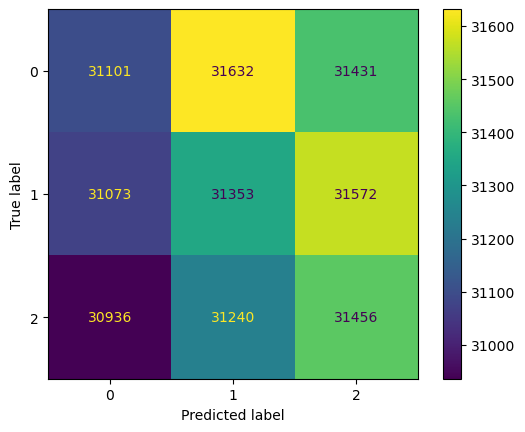

In [31]:
accuracy = accuracy_score(y_test, y_pred2)
precision = precision_score(y_test, y_pred2, average='weighted')
recall = recall_score(y_test, y_pred2, average='weighted')
f1 = f1_score(y_test, y_pred2, average='weighted')
cm = confusion_matrix(y_test, y_pred2)
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, f1 score: {f1}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Hyperparameter tuning using GridSearchCV

In [6]:
param_grid = {
    'classifier__n_estimators': [100, 200, 500],          # number of trees
    'classifier__max_depth': [None, 10, 20, 30],          # max depth of each tree
    'classifier__min_samples_split': [2, 5, 10],          # minimum samples to split a node
    'classifier__min_samples_leaf': [1, 2, 4]              # minimum samples at a leaf node
}

grid_search = GridSearchCV(
    estimator=model2, 
    param_grid=param_grid, 
    cv=5,                # 5-fold cross-validation
    scoring='accuracy',  # metric to optimize
    n_jobs=-1,           # use all processors for speed
    verbose=2            # print progress
)

# Fit to your training data
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.7s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.5s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   3.2s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=500; total time=   8.3s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   1.4s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   1.2s
[CV] END classifier__max_depth=

In [9]:
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.32      0.30      0.31       610
         Low       0.32      0.30      0.31       611
      Medium       0.34      0.37      0.35       573

    accuracy                           0.32      1794
   macro avg       0.32      0.33      0.32      1794
weighted avg       0.32      0.32      0.32      1794



## This is the result of a dataset that is too uniform and the differences between the three classes are very subtle.
- This is how the target value was calculated:
 ```python
def tercile_label(s,low_33,high_67):
    if s <= low_33:
        return 'Low'
    elif s <= high_67:
        return 'Medium'
    else:
        return 'High'
```
where 
- **Low**: salary ≤ `low_33`  (salaries in the bottom 33%)
- **Medium**: `low_33` < salary ≤ `high_67` (salaries between the 33rd and 67th percentile)
- **High**: salary > `high_67` (salaries in the top 33%)

Given the distribution of the average salaries: 

In [23]:
print(df["Salary_Tercile"].unique())

['Medium' 'Low' 'High']


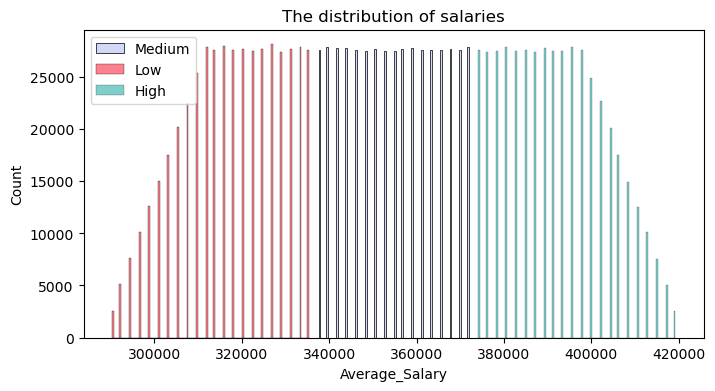

In [32]:
plot_distribution_pairs(df,"Average_Salary","The distribution of salaries",hue="Salary_Tercile")